# Part 3 - Predictive modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns
import math
import json
from pandas.io.json import json_normalize
from datetime import date, timedelta

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

pd.options.display.max_columns=1000
sns.set_theme()

In [2]:
with open('C:/Users/marki/Desktop/SB Data Science BC/Springboard/ultimate_challenge/ultimate_data_challenge.json') as file:
    data = json.load(file)
    
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
df.shape

(50000, 12)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [5]:
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] =  pd.to_datetime(df['last_trip_date'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    41878 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    49799 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [7]:
df.isnull().any()

city                      False
trips_in_first_30_days    False
signup_date               False
avg_rating_of_driver       True
avg_surge                 False
last_trip_date            False
phone                      True
surge_pct                 False
ultimate_black_user       False
weekday_pct               False
avg_dist                  False
avg_rating_by_driver       True
dtype: bool

In [8]:
df['avg_rating_of_driver'] = round(df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean()),1)

In [9]:
df['avg_rating_by_driver'] = round(df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean()),1)

In [10]:
df['phone'] = df['phone'].fillna(df['phone'].mode().iloc[0])

In [11]:
df.isnull().sum()

city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64

In [12]:
df.columns

Index(['city', 'trips_in_first_30_days', 'signup_date', 'avg_rating_of_driver',
       'avg_surge', 'last_trip_date', 'phone', 'surge_pct',
       'ultimate_black_user', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver'],
      dtype='object')

In [13]:
first_signup = df['signup_date'].min()
print(first_signup)
last_trip = df['last_trip_date'].max()
print(last_trip)

2014-01-01 00:00:00
2014-07-01 00:00:00


In [14]:
target_retained = last_trip - timedelta(days=30)
target_retained

Timestamp('2014-06-01 00:00:00')

In [15]:
df['retained_user'] = df['last_trip_date'] >= target_retained
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,True
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,False
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,False
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,True
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,False


In [16]:
df = pd.get_dummies(df, columns=['retained_user'])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user_False,retained_user_True
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,1,0


In [17]:
df = df.drop('retained_user_False', axis=1)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user_True
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [18]:
df = df.rename(columns={'retained_user_True':'retained_user'})
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
 12  retained_user           50000 non-null  uint8 

In [20]:
df = pd.get_dummies(df, columns=['ultimate_black_user'])
df = df.drop('ultimate_black_user_False', axis=1)
df = df.rename(columns={'ultimate_black_user_True':'ultimate_black_user'})
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained_user,ultimate_black_user
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,46.2,3.67,5.0,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,50.0,8.26,5.0,0,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,100.0,0.77,5.0,0,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,80.0,2.36,4.9,1,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,82.4,3.13,4.9,0,0


In [21]:
df = pd.get_dummies(df, columns=['phone'])
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained_user,ultimate_black_user,phone_Android,phone_iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,0


In [22]:
df['phone_Android'].sum()

15022

In [23]:
df['phone_iPhone'].sum()

34978

In [24]:
df = df.rename(columns={'phone_iPhone':'iPhone', 'phone_Android':'Android'})
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained_user,ultimate_black_user,Android,iPhone
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1,0,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,1
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,0,1
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,0


In [25]:
df = pd.get_dummies(df, columns=['city'])
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained_user,ultimate_black_user,Android,iPhone,city_Astapor,city_King's Landing,city_Winterfell
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,1,1,0,1,0,1,0
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,0,0,1,0,1,0,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,0,0,0,1,1,0,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,1,1,0,1,0,1,0
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,0,0,0,1


In [26]:
print(df['city_Astapor'].sum())
print(df["city_King's Landing"].sum())
print(df['city_Winterfell'].sum())

16534
10130
23336


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   trips_in_first_30_days  50000 non-null  int64         
 1   signup_date             50000 non-null  datetime64[ns]
 2   avg_rating_of_driver    50000 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   last_trip_date          50000 non-null  datetime64[ns]
 5   surge_pct               50000 non-null  float64       
 6   weekday_pct             50000 non-null  float64       
 7   avg_dist                50000 non-null  float64       
 8   avg_rating_by_driver    50000 non-null  float64       
 9   retained_user           50000 non-null  uint8         
 10  ultimate_black_user     50000 non-null  uint8         
 11  Android                 50000 non-null  uint8         
 12  iPhone                  50000 non-null  uint8 

In [29]:
target_names = 'signup_date last_trip_date retained_user'.split()
target_names

['signup_date', 'last_trip_date', 'retained_user']

In [30]:
fn = list()
for i, name in enumerate(df.columns):
    if i > 100:
        break
    if name in target_names:
        continue
    fn.append(name)

In [31]:
X = df[fn]
y = df['retained_user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=1)

In [32]:
y_train.value_counts()

0    25018
1    14982
Name: retained_user, dtype: int64

In [33]:
hyper_table = list()

In [34]:
model_rf0 = RandomForestClassifier(n_estimators=200, random_state = 1, n_jobs=-1, class_weight='balanced')

model_rf0.fit(X_train[fn], y_train)
y_pred = model_rf0.predict(X_test[fn])

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

hyper_table.append(dict(model=model_rf0, 
                        sample='unbalanced',
                        accuracy=accuracy, 
                        precision=precision, 
                        recall=recall, 
                        f1_score=f1))

12


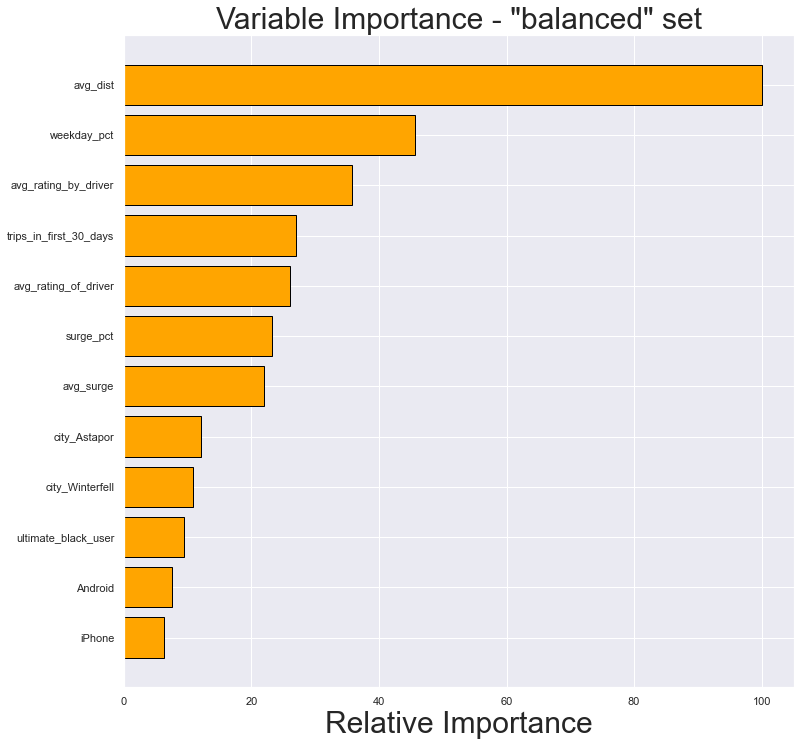

In [35]:
feature_importance = model_rf0.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], color='orange', edgecolor='black', align='center')
plt.yticks(pos, df[fn].columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=30)
plt.title('Variable Importance - "balanced" set', fontsize=30)
plt.grid(True)
plt.show()

In [36]:
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 1.659


In [37]:
counter

Counter({1: 18804, 0: 31196})

Fitting 10 folds for each of 9 candidates, totalling 90 fits


C:\Users\marki\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.466424 using {'max_depth': 5, 'n_estimators': 100}
-0.469551 (0.008956) with: {'max_depth': 3, 'n_estimators': 100}
-0.467296 (0.008881) with: {'max_depth': 3, 'n_estimators': 200}
-0.466806 (0.009018) with: {'max_depth': 3, 'n_estimators': 300}
-0.466424 (0.010747) with: {'max_depth': 5, 'n_estimators': 100}
-0.469248 (0.010858) with: {'max_depth': 5, 'n_estimators': 200}
-0.473157 (0.010266) with: {'max_depth': 5, 'n_estimators': 300}
-0.473349 (0.010460) with: {'max_depth': 7, 'n_estimators': 100}
-0.485463 (0.011865) with: {'max_depth': 7, 'n_estimators': 200}
-0.498065 (0.012838) with: {'max_depth': 7, 'n_estimators': 300}


Text(0, 0.5, 'Log Loss')

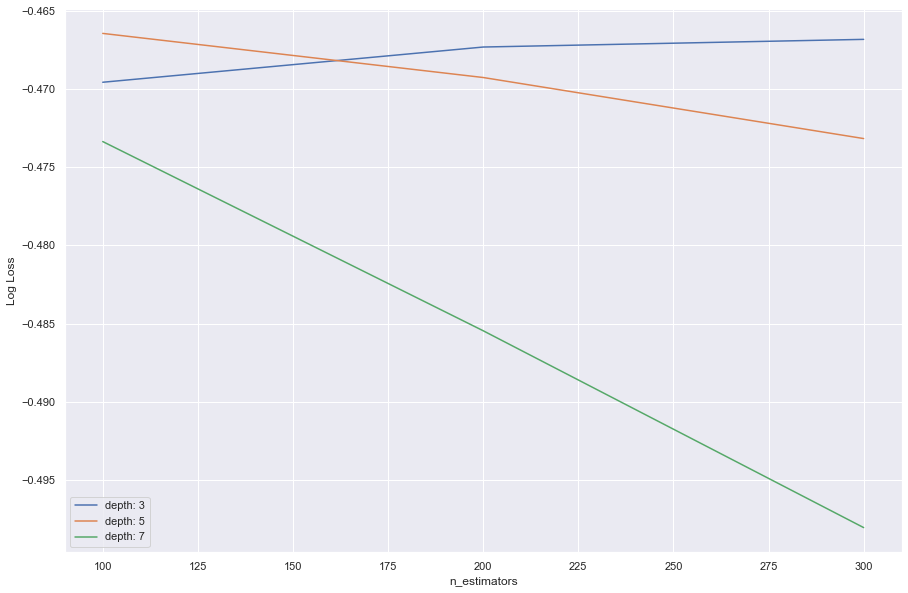

In [38]:
model = XGBClassifier(scale_pos_weight=estimate)

n_estimators = [100, 200, 300]
max_depth = [3, 5, 7]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.figure(figsize=(15,10))
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

C:\Users\marki\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:22:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


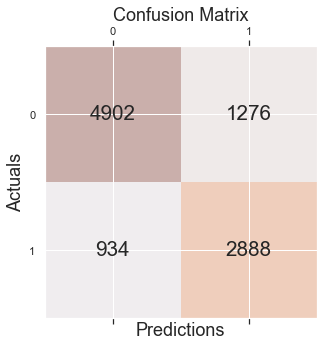

In [39]:
model_XGB = XGBClassifier(n_estimators=100, max_depth=5, scale_pos_weight=estimate, random_state=1)
model_XGB.fit(X_train[fn], y_train)
y_pred = model_XGB.predict(X_test[fn])

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

hyper_table.append(dict(model=model_XGB, 
                        sample='unbalanced',  
                        accuracy=accuracy, 
                        precision=precision, 
                        recall=recall, 
                        f1_score=f1)) 

In [40]:
df_train = pd.concat([pd.DataFrame(X_train, columns=fn), pd.DataFrame(y_train, columns=['retained_user'])], axis=1)

In [41]:
print(df_train.shape)

(40000, 13)


In [42]:
df_grouped_train = df_train.groupby('retained_user')
df_grouped_train.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,Android,iPhone,city_Astapor,city_Winterfell,retained_user
18165,6,4.7,1.00,0.0,100.0,4.88,4.8,1,0,1,1,0,0
36059,2,4.5,1.00,0.0,75.0,1.18,5.0,1,0,1,0,1,1
13242,1,4.0,1.00,0.0,100.0,9.28,5.0,1,0,1,0,1,0
32985,11,4.9,1.04,3.0,15.2,2.06,4.8,1,0,1,0,1,1
41133,2,4.5,1.00,0.0,63.6,4.30,4.9,1,1,0,0,1,1
9273,0,5.0,1.00,0.0,100.0,14.90,5.0,1,0,1,0,1,1
12784,1,5.0,1.00,0.0,100.0,4.10,5.0,1,0,1,0,1,0
43992,1,4.6,1.00,0.0,100.0,1.07,5.0,0,1,0,0,0,0
33452,1,5.0,1.00,0.0,0.0,11.23,5.0,0,0,1,0,0,0
6342,4,5.0,1.00,0.0,47.2,2.89,4.9,1,0,1,0,1,1


In [43]:
print(df_grouped_train.size())

retained_user
0    25018
1    14982
dtype: int64


In [44]:
list(df_grouped_train)[0][1]

lengths = []

for retained_user, group in df_grouped_train:
    lengths.append(group.shape[0])
    
print(lengths)

[25018, 14982]


In [45]:
dfs_train = list()

for retained_user, group in df_grouped_train:
    dfs_train.append(group.sample(max(lengths), replace=True))
    
dfs_train

[       trips_in_first_30_days  avg_rating_of_driver  avg_surge  surge_pct  \
 24851                       5                   4.0       1.18       28.6   
 36979                       1                   4.6       1.00        0.0   
 45401                       0                   4.6       1.00        0.0   
 4795                        0                   3.3       1.27       27.3   
 38684                       1                   5.0       1.00        0.0   
 ...                       ...                   ...        ...        ...   
 18647                       0                   4.6       1.00        0.0   
 27583                       2                   5.0       1.00        0.0   
 19778                       0                   4.6       2.00      100.0   
 19581                       5                   5.0       1.00        0.0   
 29182                       2                   5.0       1.00        0.0   
 
        weekday_pct  avg_dist  avg_rating_by_driver  ultimate_

In [46]:
df_balancedbyover = pd.concat(dfs_train)
df_balancedbyover.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,Android,iPhone,city_Astapor,city_Winterfell,retained_user
24851,5,4.0,1.18,28.6,0.0,2.65,4.4,0,0,1,0,1,0
36979,1,4.6,1.00,0.0,0.0,3.84,5.0,1,1,0,1,0,0
45401,0,4.6,1.00,0.0,100.0,6.01,5.0,1,0,1,1,0,0
4795,0,3.3,1.27,27.3,100.0,2.95,4.2,0,0,1,0,1,0
38684,1,5.0,1.00,0.0,100.0,1.03,5.0,0,0,1,0,1,0


In [47]:
df_balancedbyover.shape

(50036, 13)

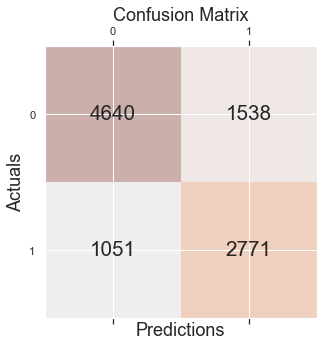

In [48]:
model_rf = RandomForestClassifier(n_estimators=200, random_state = 1, n_jobs=-1)

model_rf.fit(df_balancedbyover[fn], df_balancedbyover['retained_user'])
y_pred = model_rf.predict(X_test[fn])

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

hyper_table.append(dict(model=model_rf, 
                        sample='over',  
                        accuracy=accuracy, 
                        precision=precision, 
                        recall=recall, 
                        f1_score=f1))

12


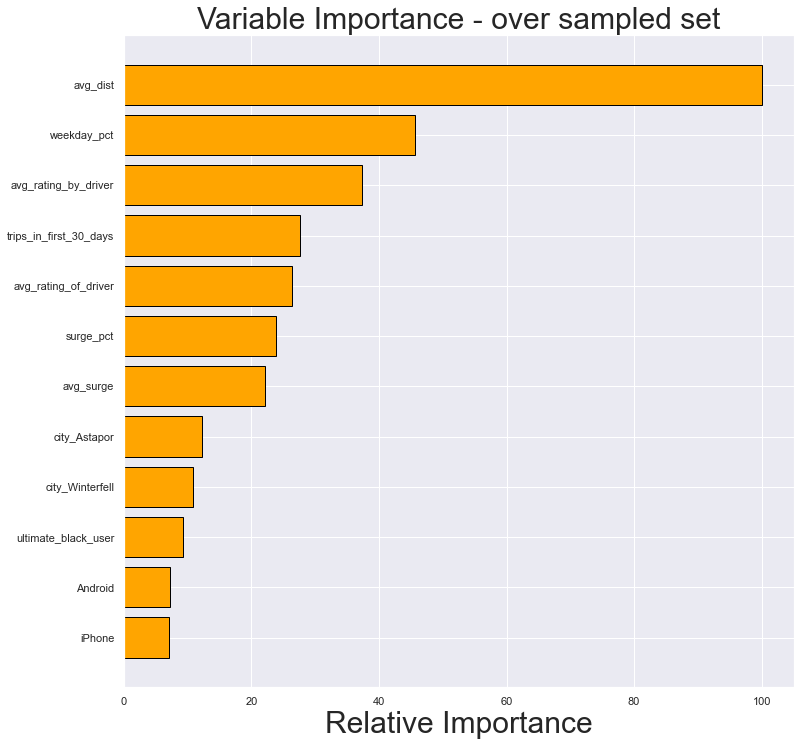

In [49]:
feature_importance = model_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], color='orange', edgecolor='black', align='center')
plt.yticks(pos, df_balancedbyover[fn].columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=30)
plt.title('Variable Importance - over sampled set', fontsize=30)
plt.grid(True)
plt.show()

Fitting 10 folds for each of 9 candidates, totalling 90 fits


C:\Users\marki\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.448923 using {'max_depth': 3, 'n_estimators': 200}
-0.451006 (0.009708) with: {'max_depth': 3, 'n_estimators': 100}
-0.448923 (0.009264) with: {'max_depth': 3, 'n_estimators': 200}
-0.448974 (0.009167) with: {'max_depth': 3, 'n_estimators': 300}
-0.448945 (0.010258) with: {'max_depth': 5, 'n_estimators': 100}
-0.453020 (0.009767) with: {'max_depth': 5, 'n_estimators': 200}
-0.458163 (0.009353) with: {'max_depth': 5, 'n_estimators': 300}
-0.458196 (0.011337) with: {'max_depth': 7, 'n_estimators': 100}
-0.469812 (0.011772) with: {'max_depth': 7, 'n_estimators': 200}
-0.482976 (0.012175) with: {'max_depth': 7, 'n_estimators': 300}


Text(0, 0.5, 'Log Loss')

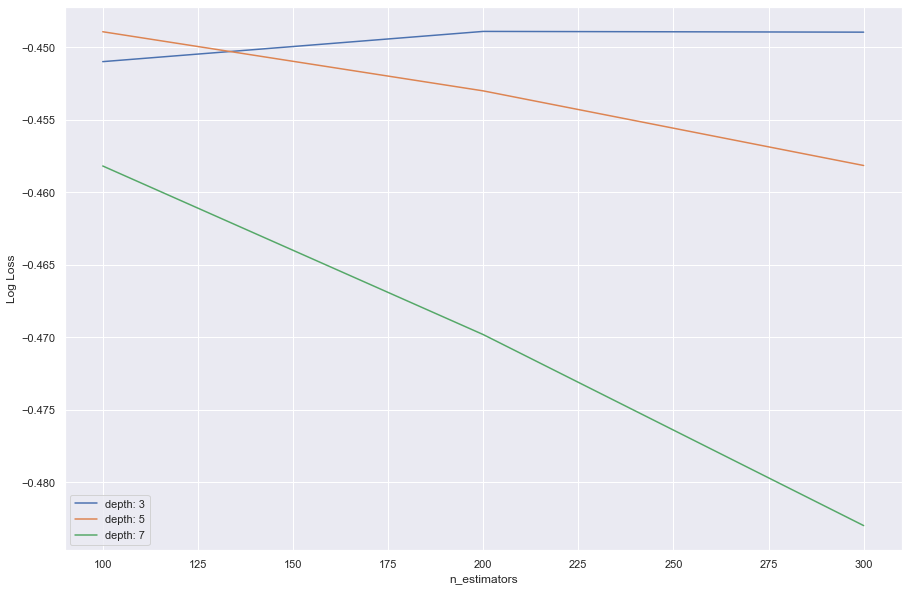

In [50]:
model = XGBClassifier()

n_estimators = [100, 200, 300]
max_depth = [3, 5, 7]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X, y)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.figure(figsize=(15,10))
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')

C:\Users\marki\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:25:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


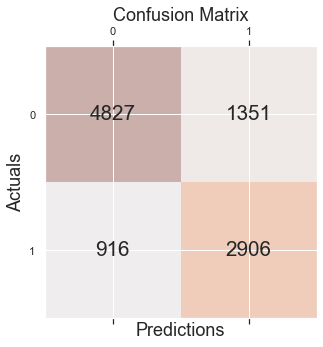

In [51]:
model_XGB = XGBClassifier(n_estimators=200, max_depth=3, random_state=1)
model_XGB.fit(df_balancedbyover[fn], df_balancedbyover['retained_user'])
y_pred = model_XGB.predict(X_test[fn])

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

hyper_table.append(dict(model=model_XGB, 
                        sample='over',  
                        accuracy=accuracy, 
                        precision=precision, 
                        recall=recall, 
                        f1_score=f1))

In [52]:
dfs_train_under = list()

for retained_user, group in df_grouped_train:
    dfs_train.append(group.sample(min(lengths)))
    
dfs_train_under

[]

In [53]:
df_balancedbyunder = pd.concat(dfs_train)
df_balancedbyunder.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,ultimate_black_user,Android,iPhone,city_Astapor,city_Winterfell,retained_user
24851,5,4.0,1.18,28.6,0.0,2.65,4.4,0,0,1,0,1,0
36979,1,4.6,1.00,0.0,0.0,3.84,5.0,1,1,0,1,0,0
45401,0,4.6,1.00,0.0,100.0,6.01,5.0,1,0,1,1,0,0
4795,0,3.3,1.27,27.3,100.0,2.95,4.2,0,0,1,0,1,0
38684,1,5.0,1.00,0.0,100.0,1.03,5.0,0,0,1,0,1,0


In [54]:
df_balancedbyunder.shape

(80000, 13)

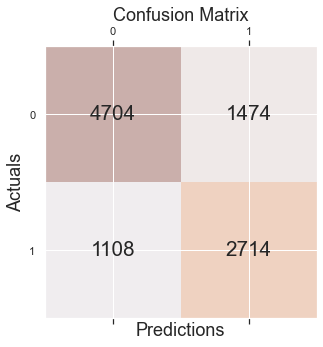

In [55]:
model_rf.fit(df_balancedbyunder[fn], df_balancedbyunder['retained_user'])
y_pred = model_rf.predict(X_test[fn])

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

hyper_table.append(dict(model=model_rf, 
                        sample='under',  
                        accuracy=accuracy, 
                        precision=precision, 
                        recall=recall, 
                        f1_score=f1))

12


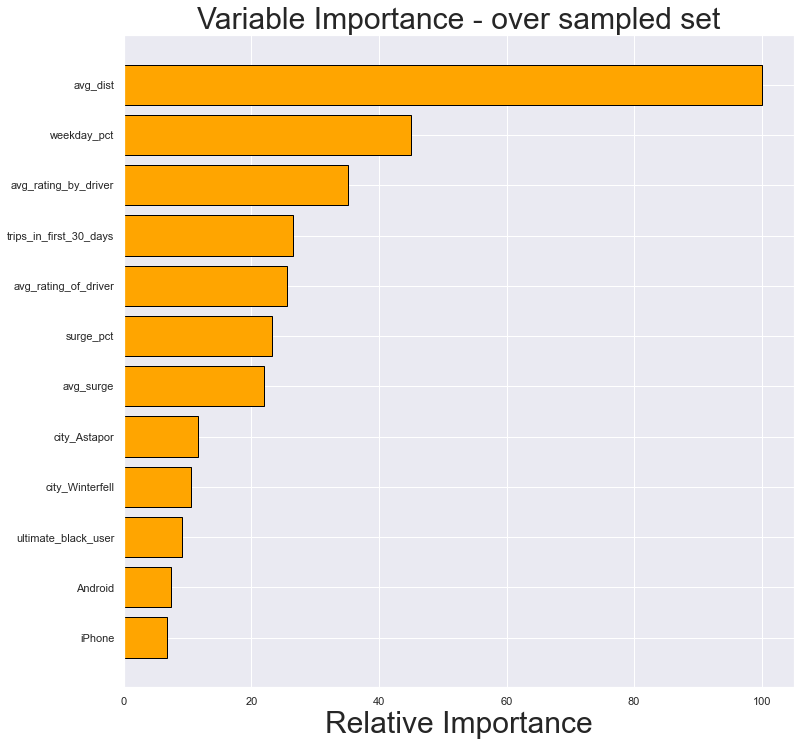

In [56]:
feature_importance = model_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(12,12))
plt.barh(pos, feature_importance[sorted_idx], color='orange', edgecolor='black', align='center')
plt.yticks(pos, df_balancedbyunder[fn].columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=30)
plt.title('Variable Importance - under sampled set', fontsize=30)
plt.grid(True)
plt.show()

C:\Users\marki\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:31:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


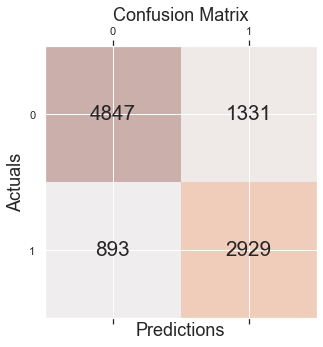

In [58]:
model_XGB = XGBClassifier(n_estimators=200, max_depth=3, random_state=1)
model_XGB.fit(df_balancedbyunder[fn], df_balancedbyunder['retained_user'])
y_pred = model_XGB.predict(X_test[fn])

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

hyper_table.append(dict(model=model_XGB, 
                        sample='under',  
                        accuracy=accuracy, 
                        precision=precision, 
                        recall=recall, 
                        f1_score=f1))

In [60]:
ht = pd.DataFrame(hyper_table).sort_values('accuracy', ascending=False)
ht

,model,sample,accuracy,precision,recall,f1_score
1,"XGBClassifier(base_score=0.5, booster='gbtree'...",unbalanced,0.7790,0.693564,0.755625,0.723266
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",under,0.7776,0.687559,0.766353,0.724821
3,"XGBClassifier(base_score=0.5, booster='gbtree'...",over,0.7733,0.682640,0.760335,0.719396
0,"(DecisionTreeClassifier(max_features='auto', r...",unbalanced,0.7547,0.686157,0.660126,0.672890
4,"(DecisionTreeClassifier(max_features='auto', r...",under,0.7418,0.648042,0.710099,0.677653
2,"(DecisionTreeClassifier(max_features='auto', r...",over,0.7411,0.643073,0.725013,0.681589


In [61]:
fraction_retained = df['retained_user'].sum()/len(df['retained_user'])
fraction_retained

0.37608

1) It looks like 37.6% of users were retained.

2) The models I chose were Random Forest Classifier, because it is a well performing classifier and XGBoost classifier because it is slightly more accurate than the Random Forest Classifier. I thought about Logistic Regression as well for classification however, in my experience with these models, Logistic Regression does not perform as well. A concern I have is the unbalanced data. There are nearly twice as many users as there are retained users. The most accurate model I have is the XGBoost model run on the original unbalanced dataset. This model also gave me the highest precision, and top 3 recall and f1 scores.

3) It looks like average distance per trip taken in the first 30 days after signup (avg_dist), the percent of the user's trips occurring during a weekday (weekday_pct), and the rider's average rating over all of their trips (avg_rating_by_driver) are the most important features. In order to leverage these to retain users it would be beneficial to offer some incentives to taking a trip within the first 30 days of signup. Also it might make sense to 